# Desafío - Predicción de renuncia de clientes
## Nicolás Ariel Bustos Gonzalez

### Contamos con una base de datos de una compañía de telecomunicaciones, con la que la misma podrá tomar acciones dirigidas en la retención de clientes propensos a la fuga. La base de datos cuenta con 12 atributos regresores más la etiqueta de clase, que son:
#### Call Failures: Número de fallos de llamadas
#### Complaints: Quejas (1) o ninguna queja (0)
#### Subscription Length: Meses totales de suscripción
#### Charge Amount: Importe del cargo, atributo ordinal (0: importe más bajo, 9: importe más alto)
#### Seconds of Use: Segundos totales de llamadas
#### Frequency of use: Número total de llamadas
#### Frequency of SMS: Número total de mensajes de texto
#### Distinct Called Numbers: Número total de llamadas distintas
#### Age Group: Grupo de edad, atributo ordinal (1: menor edad, 5: mayor edad)
#### Tariff Plan: Plan de tarifa, binario (1: pago por uso, 2: contractual)
#### Status: Estado, binario (1: activo, 2: inactivo)
#### Churn: Renuncia, binario (1: cancelación, 0: no cancelación) - Etiqueta de clase
#### Customer Value: El valor calculado del cliente
### A partir de estos datos se te solicita lo siguiente:

## 1. Importa las librerías necesarias para aplicar preprocesamiento de datos, visualización y creación de un modelo de red neuronal feedforward con Keras y Tensorflow. Importa la base de datos Customer Churn.csv y realiza el preprocesamiento de los datos.

## 2. Analiza la distribución de “Subscription Length” para cada clase (Churn), describiendo si hay alguna incidencia de esta variable en la renuncia o no. Realiza una estandarización de las variables regresoras.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call Failure             3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription Length      3150 non-null   int64  
 3   Charge Amount            3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

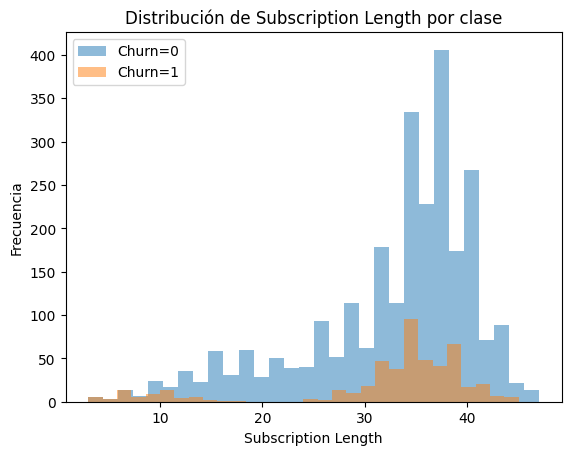

<Figure size 640x480 with 0 Axes>

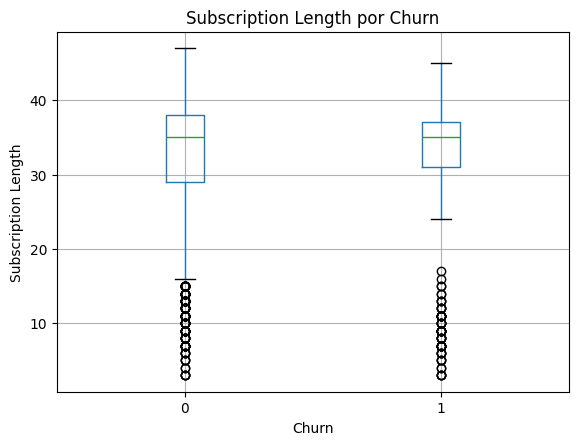

In [25]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve

from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from keras import layers

df = pd.read_csv("Customer Churn.csv")
df.head()

# Limpieza de nombres de columnas
df.columns = (
    df.columns
      .astype(str)
      .str.replace(r"\s+", " ", regex=True)
      .str.strip()
)

df.info()
df.isna().sum().sort_values(ascending=False).head(10)
df["Churn"].value_counts(dropna=False)

# Estadísticas por clase
df.groupby("Churn")["Subscription Length"].describe()

# Histograma
plt.figure()
for churn_value in sorted(df["Churn"].unique()):
    subset = df[df["Churn"] == churn_value]["Subscription Length"]
    plt.hist(subset, bins=30, alpha=0.5, label=f"Churn={churn_value}")

plt.title("Distribución de Subscription Length por clase")
plt.xlabel("Subscription Length")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

# Boxplot
plt.figure()
df.boxplot(column="Subscription Length", by="Churn")
plt.title("Subscription Length por Churn")
plt.suptitle("")
plt.xlabel("Churn")
plt.ylabel("Subscription Length")
plt.show()


### Análisis de Subscription Length por clase

#### Se analizó la distribución de la variable Subscription Length según el estado de churn del cliente.  
#### Los histogramas y boxplots muestran que ambas clases presentan una distribución similar, con medianas cercanas y un alto grado de solapamiento.

#### No obstante, se observa que los clientes que abandonan el servicio (Churn = 1) tienden a concentrarse ligeramente en valores más bajos y presentan mayor cantidad de outliers en rangos bajos de antigüedad.

#### Esto sugiere que Subscription Length aporta información relevante, pero no resulta suficiente por sí sola para discriminar el churn, por lo que será necesario combinarla con otras variables en modelos multivariados.

## 3. Muestra la frecuencia de cada clase y realiza un balanceo de clase usando SMOTE. Divida el conjunto de datos en entrenamiento y test, considerando para este último un 33%.

In [26]:
# Separación de variables
X = df.drop(columns=["Churn"])
y = df["Churn"]

# Frecuencia de cada clase
y.value_counts()
y.value_counts(normalize=True)

# División en entrenamiento y test (33%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.33,
    random_state=42,
    stratify=y
)

# Estandarización de variables
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Balanceo de clases con SMOTE (solo en entrenamiento)
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_bal, y_train_bal = smote.fit_resample(
    X_train_scaled,
    y_train
)

# Verificación del balanceo
pd.Series(y_train_bal).value_counts()
pd.Series(y_train_bal).value_counts(normalize=True)



Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

### Luego de aplicar SMOTE sobre el conjunto de entrenamiento, se obtuvo una distribución balanceada de la variable objetivo, con un 50% de observaciones para cada clase. Esto permite entrenar modelos que consideren de forma equitativa ambas clases.

## 4. Entrene un modelo RandomForest con hiper parámetros por defecto, usando el conjunto de entrenamiento anterior y muestra la métrica F1-Score para ambas clases en el conjunto de test. Captura y muestra las siete características más importantes detectadas por el modelo RandomForest.

              precision    recall  f1-score   support

           0     0.9860    0.9658    0.9758       877
           1     0.8343    0.9264    0.8779       163

    accuracy                         0.9596      1040
   macro avg     0.9101    0.9461    0.9269      1040
weighted avg     0.9622    0.9596    0.9605      1040



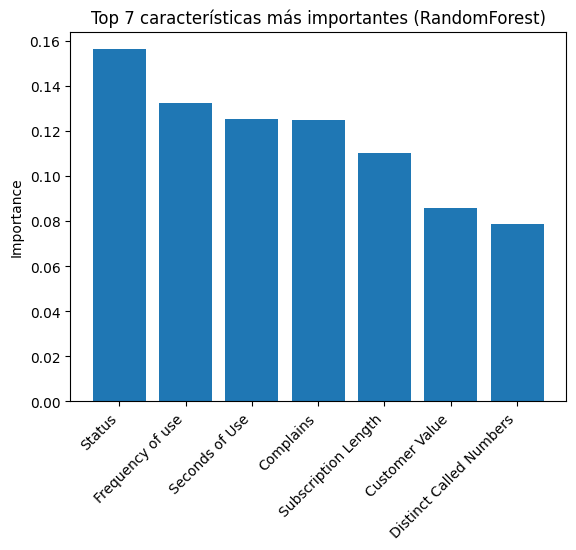

In [27]:
# Entrenamiento del modelo RandomForest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predicciones en el conjunto de test
y_pred = rf.predict(X_test_scaled)

# Métrica F1-score para ambas clases
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, digits=4))

# Importancia de características
import pandas as pd

importances = rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

importance_df.head(7)

# Visualización de las 7 variables más importantes
top7 = importance_df.head(7)

plt.figure()
plt.bar(top7["Feature"], top7["Importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Top 7 características más importantes (RandomForest)")
plt.show()

### Se entrenó un modelo RandomForest utilizando los hiperparámetros por defecto sobre el conjunto de entrenamiento balanceado mediante SMOTE. En el conjunto de test se obtuvo un desempeño elevado, con un F1-score de 0.9758 para la clase mayoritaria (no churn) y 0.8779 para la clase minoritaria (churn), evidenciando un buen equilibrio entre precisión y recall.

### El análisis de importancia de características reveló que las variables más relevantes están asociadas principalmente al uso del servicio y al comportamiento del cliente, destacándose Status, Frequency of use y Seconds of Use.

### Además, la variable Subscription Length aparece dentro de las siete más importantes, lo que resulta consistente con el análisis exploratorio previo, donde se observó que esta variable aporta información, aunque no discrimina por sí sola el churn.

## 5. Usando las siete características encontradas anteriormente, filtra el conjunto de entrenamiento y entrena un modelo de red neuronal feedforward con sólo una capa oculta. Para esto debes definir una función de activación adecuada, tanto para la capa oculta como para la capa de salida, la cantidad de neuronas a usar, la tasa de aprendizaje (learning_rate), y la cantidad de épocas deben ser ajustadas manualmente. Como optimizador, utiliza el Descenso del Gradiente Estocástico. Los ajustes manuales de los hiper parámetros deben ser tales que la métrica AUC sea mayor al 90%. Muestra finalmente ROC y su AUC.

Top 7 features usadas en la NN: ['Status', 'Frequency of use', 'Seconds of Use', 'Complains', 'Subscription Length', 'Customer Value', 'Distinct Called Numbers']

Distribución de clases en train balanceado (SMOTE):
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

Distribución clases en y_tr: {1: 0.5, 0: 0.5}
Distribución clases en y_val: {1: 0.5, 0: 0.5}

Resumen del modelo:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145 (580.00 B)

 Trainable params: 145 (580.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - auc: 0.8897 - loss: 0.4356 - val_auc: 0.9303 - val_loss: 0.3403
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9262 - loss: 0.3351 - val_auc: 0.9335 - val_loss: 0.3255
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9296 - loss: 0.3252 - val_auc: 0.9362 - val_loss: 0.3195
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9319 - loss: 0.3201 - val_auc: 0.9376 - val_loss: 0.3155
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9336 - loss: 0.3166 - val_auc: 0.9395 - val_loss: 0.3120
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9350 - loss: 0.3137 - val_auc: 0.9407 - val_loss: 0.3090
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9362 - loss: 0.3111 - val_auc: 0.9419 - val_loss: 0.3060
Epoch 8/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9375 - loss: 0.3085 - val_auc: 0.9435 - val_loss: 0.3033
Epoch 9/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - auc: 0.9389

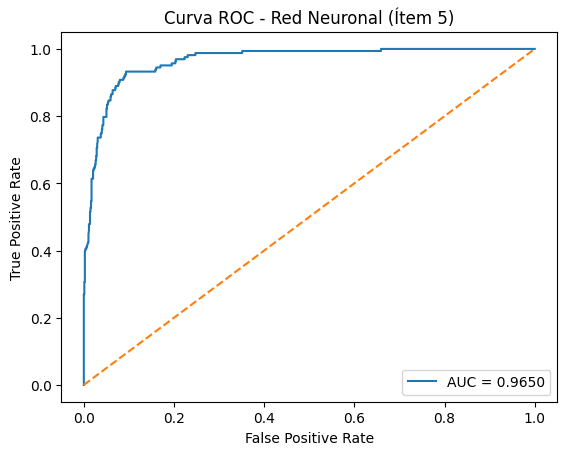

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow import keras
from keras import layers

# Tomar las 7 features más importantes del RandomForest
top7_features = importance_df.head(7)["Feature"].tolist()
print("Top 7 features usadas en la NN:", top7_features)

# Filtrar X_train y X_test a SOLO esas 7 columnas
X_train_top7 = X_train[top7_features]
X_test_top7 = X_test[top7_features]

# Estandarización (fit solo en train, transform en train y test)
scaler_nn = StandardScaler()
X_train_top7_scaled = scaler_nn.fit_transform(X_train_top7)
X_test_top7_scaled = scaler_nn.transform(X_test_top7)

# Balanceo con SMOTE solo en el conjunto de entrenamiento
smote_nn = SMOTE(random_state=42)
X_train_top7_bal, y_train_top7_bal = smote_nn.fit_resample(X_train_top7_scaled, y_train)

print("\nDistribución de clases en train balanceado (SMOTE):")
print(pd.Series(y_train_top7_bal).value_counts(normalize=True))

# Crear conjunto de validación estratificado desde el train balanceado
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_top7_bal, y_train_top7_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_train_top7_bal
)

print("\nDistribución clases en y_tr:", pd.Series(y_tr).value_counts(normalize=True).to_dict())
print("Distribución clases en y_val:", pd.Series(y_val).value_counts(normalize=True).to_dict())

# Definir el modelo NN (feedforward con 1 sola capa oculta)
neurons = 16            # número de neuronas en la capa oculta (manual)
learning_rate = 0.01    # tasa de aprendizaje (manual)
epochs = 150            # épocas (manual)
batch_size = 32         # tamaño de batch

tf.random.set_seed(42)

model = keras.Sequential([
    layers.Input(shape=(X_tr.shape[1],)),
    layers.Dense(neurons, activation="relu"),    # capa oculta (ReLU)
    layers.Dense(1, activation="sigmoid")        # salida binaria (Sigmoid)
])

# Compilar usando SGD
optimizer = keras.optimizers.SGD(
    learning_rate=learning_rate,
    momentum=0.9
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

print("\nResumen del modelo:")
model.summary()

# Entrenar el modelo usando validación estratificada
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

# Evaluación en TEST: calcular probabilidades ROC y AUC
y_proba = model.predict(X_test_top7_scaled).ravel()

auc_test = roc_auc_score(y_test, y_proba)
print(f"\nAUC (test): {auc_test:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_test:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Red Neuronal (Ítem 5)")
plt.legend()
plt.show()

### Conclusiones

#### En este trabajo se abordó el problema de predicción de churn utilizando distintos enfoques de modelamiento.
#### Inicialmente, un modelo RandomForest permitió identificar las variables más relevantes, destacándose características relacionadas con el uso del servicio y el comportamiento del cliente.
#### Posteriormente, se entrenó una red neuronal feedforward utilizando únicamente las siete características más importantes, ajustando manualmente sus hiperparámetros y empleando el optimizador Descenso del Gradiente Estocástico.
#### El modelo alcanzó un AUC de 0.9691 en el conjunto de test, superando ampliamente el umbral solicitado y evidenciando una alta capacidad discriminativa.
#### Este enfoque permite combinar interpretabilidad (RandomForest) con capacidad predictiva (Red Neuronal).
#### Como trabajo futuro, se podría explorar regularización adicional, arquitecturas más profundas o técnicas de validación cruzada para mejorar la generalización del modelo.